# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию. Ищем проблемы и неточности в данных.

In [1]:
import pandas as pd
!pip install seaborn
!pip install pymystem3
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
m = Mystem()
data=pd.read_csv("https://code.s3.yandex.net/datasets/data.csv")
data.info()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [2]:
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


## Оценка данных, проверка качества названий столбцов.

In [3]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

В целом названия столбцов соответствуют содержимому. Переименовать для удобства можно 3 столбца - возраст, тип занятости и месячный доход.

In [4]:
data = data.rename(columns={'dob_years':'age', 'income_type':'type_activity','total_income':'monthly_income'})
data.head(15)

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,type_activity,debt,monthly_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Создадим функцию для оценки содержимого отдельных столбцов. Функция примет столбец, вернет mean, min, max, уникальные значения по столбцам. Для столбцов с текстовым содержимым вернет только количество наблюдений и уникальные значения.

In [5]:
def series_analise(series):
    print(series.name)
    try: # при попадении данных не верного типа в расчет посчитает только то что можно посчитать в любом случае.
        return f"Для этого столбца Среднеее значение:{series.mean()}" + "\n" + f"Максимальное значение: {series.max()}"+ "\n" + f"Минимальное значение: {series.min()}"+ "\n" + f"Всего наблюдений: {series.count()}" + "\n" + f"Уникальные значения: {series.unique()}"
    except:
        return f"Для этого столбца" + "\n" f"Всего наблюдений: {series.count()}" + "\n" + f"Уникальные значения: {series.unique()}"

Последовательно применю к всем столбцам. Ищу особенности в данных.

In [6]:
print(series_analise(data["children"]))

children
Для этого столбца Среднеее значение:0.5389082462253194
Максимальное значение: 20
Минимальное значение: -1
Всего наблюдений: 21525
Уникальные значения: [ 1  0  3  2 -1  4 20  5]


Столбец "количество детей в семье". Максимальное значение представляется слишком большим (20 детей), требует проверки.
Присутствует отрицательное значение (требует предобработки).
Пропущенных значений нет. Происхождение ошибок: вероятно, ошибка при занесении данных.

In [7]:
print(series_analise(data["days_employed"]))

days_employed
Для этого столбца Среднеее значение:63046.49766147338
Максимальное значение: 401755.40047533
Минимальное значение: -18388.949900568383
Всего наблюдений: 19351
Уникальные значения: [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]


Столбец "общий трудовой стаж в днях". Присутствуют отрицательные значения, требует предобрабоки. Тип данных float требует предобработки, правки на int. Присутствуют пропущенные значения. Среднее значение не может быть таким большим, требует анализа. Происхождение ошибок: вероятно, ошибка при занесении данных.

In [8]:
print(series_analise(data["age"]))

age
Для этого столбца Среднеее значение:43.29337979094077
Максимальное значение: 75
Минимальное значение: 0
Всего наблюдений: 21525
Уникальные значения: [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]


Столбец "возраст". Обращет на себя внимание значение 0, требует проверки. Пропущенных значений нет. Тип данных в  порядке. Вероятно, потребуется категоризация данных. Происхождение ошибок: вероятно, ошибка при занесении данных.

In [9]:
print(series_analise(data["education"]))
print(data["education"].isna().sum())

education
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
0


Пропущенных значений нет. Требуется предобработка, правка регистра данных. Происхождение ошибок: вероятно, ошибка при занесении, опечатки в названиях.

In [10]:
print(series_analise(data["education_id"]))

education_id
Для этого столбца Среднеее значение:0.8172357723577236
Максимальное значение: 4
Минимальное значение: 0
Всего наблюдений: 21525
Уникальные значения: [0 1 2 3 4]


Пропущенных значений нет. Подтверждает догадку выше, после правки регистра образования, останется 5 типов образования. Столбец не требует предобработки.

In [11]:
print(series_analise(data["family_status"]))

family_status
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']


Пропусков значений нет.  Можно привести буквы к нижнему регистру. Соответствует столбцу с id семейного статуса.

In [12]:
print(series_analise(data["family_status_id"]))

family_status_id
Для этого столбца Среднеее значение:0.9725435540069687
Максимальное значение: 4
Минимальное значение: 0
Всего наблюдений: 21525
Уникальные значения: [0 1 2 3 4]


Пропусков нет. Столбец не требует предобработки.

In [13]:
print(series_analise(data["gender"]))
print("Люди с необычным полом",data.loc[data["gender"]=="XNA", 'gender'].count())
data.loc[data["gender"]=="XNA", 'gender']='M' #Особенное измерение всего 1 можно поменять на любой из полов (мы не допустим!).
print(series_analise(data["gender"]))  #Проверим исправленое.

gender
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['F' 'M' 'XNA']
Люди с необычным полом 1
gender
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['F' 'M']


In [14]:
print(series_analise(data["type_activity"]))

type_activity
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']


Пропущенных значений нет. Столбец не требует предобработки.

In [15]:
print(series_analise(data["debt"]))

debt
Для этого столбца Среднеее значение:0.08088269454123112
Максимальное значение: 1
Минимальное значение: 0
Всего наблюдений: 21525
Уникальные значения: [0 1]


Пропущенных значений нет. Данные не требуют предобработки.

In [16]:
print(series_analise(data["monthly_income"]))

monthly_income
Для этого столбца Среднеее значение:167422.30220817294
Максимальное значение: 2265604.028722744
Минимальное значение: 20667.26379327158
Всего наблюдений: 19351
Уникальные значения: [253875.6394526  112080.01410244 145885.95229686 ...  89672.56115303
 244093.05050043  82047.41889948]


Присутствуют пропуски, требуют дальнейшего анализа. Тип данных можно сменить на int.

In [17]:
print(series_analise(data["purpose"]))

purpose
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'ремо

Пропусков нет. Некоторые строки описывают одно и тоже по несколько раз. Требуется лемматизация, с последующей категоризацией. Данные не требуют предобработку.

## Шаг 2. Предобработка данных

### Обработка пропусков

Итак, пропуски присутствуют в столбцах days_employed и monthly_income, стаж и месячный доход. Необходимо привести значения вышеописанных столбцов, убрать отрицательные значения, для этого функция number_int_module
Пропуски в столбцах планирую заменить средними значениями. Затем исправить float на int.

In [18]:
def number_module(value): #Функция вернет  модуль числа. Если nan  вернет nan.
    try:
        return abs(value)
    except:
        return value

Применим number_module к столбцу children.

In [19]:
data["children"]=number_module(data["children"])
print("Родители герои",data[data["children"]== 20]["children"].count()) #76 человек имеют 20 детей опечатка при вводе данных или родители герои ?
print(data.groupby('children')['age'].mean()) 
data.loc[data["children"]==20, 'children']=2


Родители герои 76
children
0     46.261432
1     38.406783
2     35.770316
3     36.287879
4     36.048780
5     38.777778
20    41.815789
Name: age, dtype: float64


При проверке средний возраст родителей героев несколько выше чем у 1-5 детных. Может быть как ошорбка вводв так и аномалия. Но отсутствую дети 6 - 19. Больше данных за ошибку. Значение превратим в 2.

Применим number_module к столбцу days_employed.

In [20]:
data["days_employed"]= number_module(data["days_employed"])
#Проверим столбец:
print(series_analise(data["days_employed"]))

days_employed
Для этого столбца Среднеее значение:66914.72890682236
Максимальное значение: 401755.40047533
Минимальное значение: 24.14163324048118
Всего наблюдений: 19351
Уникальные значения: [8437.67302776 4024.80375385 5623.42261023 ... 2113.3468877  3112.4817052
 1984.50758853]


Применим number_module к столбцу monthly_income.

In [21]:
data["monthly_income"]= number_module(data["monthly_income"])
#Проверим столбец:
print(series_analise(data["monthly_income"]))

monthly_income
Для этого столбца Среднеее значение:167422.30220817294
Максимальное значение: 2265604.028722744
Минимальное значение: 20667.26379327158
Всего наблюдений: 19351
Уникальные значения: [253875.6394526  112080.01410244 145885.95229686 ...  89672.56115303
 244093.05050043  82047.41889948]


Заполним пропущенные значения по столбцу, days_employed. Monthly_income заполним медианными значениями с учетом характера деятельности.

In [22]:
data['days_employed'] = data['days_employed'].fillna(data['days_employed'].mean())


#data['monthly_income'] = data['monthly_income'].fillna(data['monthly_income'].mean()) СМ ниже

#Проверим таблицу.
data.info()
#Пропусков не обнаружено.
print("Пропуски",data.isnull().sum())
#Проверим столбцы:
print(series_analise(data["days_employed"]))
print(series_analise(data["monthly_income"]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
age                 21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
type_activity       21525 non-null object
debt                21525 non-null int64
monthly_income      19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
Пропуски children               0
days_employed          0
age                    0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
type_activity          0
debt                   0
monthly_income      2174
purpose                0
dtype: int64
days_e

<div class="alert alert-info" style="background:dark; color:white;>
<h2> Комментарий студента</h2>

Пробую исправить замечание:
    Анализирую подходящие для более точного расчета среднего заработка параметры.
</div>


In [23]:
print("Образование и зарплата",data.groupby('education')['monthly_income'].median().sort_values())
print("Возраст и зарплата",data.groupby('age')['monthly_income'].median().sort_values())
print("Тип занятости и зарплата",data.groupby('type_activity')['monthly_income'].median().sort_values())

Образование и зарплата education
Ученая степень          98752.495442
Начальное              104570.429306
начальное              117314.518552
НАЧАЛЬНОЕ              129666.892242
СРЕДНЕЕ                134305.753361
Среднее                135105.847892
среднее                136643.346470
неоконченное высшее    159780.923803
Неоконченное высшее    160402.480835
НЕОКОНЧЕННОЕ ВЫСШЕЕ    163911.559034
ВЫСШЕЕ                 167242.211789
высшее                 175625.312376
Высшее                 180720.652515
ученая степень         185687.118172
УЧЕНАЯ СТЕПЕНЬ         198570.757322
Name: monthly_income, dtype: float64
Возраст и зарплата age
74     76850.325847
19     93343.132708
69    104312.983461
20    109502.056040
72    110985.525593
66    111673.470974
67    112656.049064
68    113208.388713
70    118062.325847
73    119190.487878
65    122934.154656
71    122934.294124
23    123162.782874
63    123952.330213
22    123995.881833
60    126161.016149
21    128265.720871
61    128936

In [24]:
def mean_type_activity(row):
    return row.fillna(row.median())
    
    

print("До",data["monthly_income"].isna().sum())
data['monthly_income'] = data.groupby('type_activity')['monthly_income'].transform(mean_type_activity)
#print(data.groupby('type_activity')['monthly_income'])
print("После",data["monthly_income"].isna().sum()) 
print("Тип занятости и зарплата",data.groupby('type_activity')['monthly_income'].median().sort_values())

До 2174
После 0
Тип занятости и зарплата type_activity
в декрете           53829.130729
студент             98201.625314
пенсионер          118514.486412
безработный        131339.751676
сотрудник          142594.396847
госслужащий        150447.935283
компаньон          172357.950966
предприниматель    499163.144947
Name: monthly_income, dtype: float64


In [25]:
# КОД РЕВЬЮЕРА

# Создам датафрейм.


l = {'A':[1,2,4], 'B':[3,3,5]}

dfq = pd.DataFrame(l)
dfq

,A,B
0,1,3
1,2,3
2,4,5


In [26]:
# КОД РЕВЬЮЕРА

# Обычная функция. 
def squared(df):
    ''' 
    Функция принимает таблицу, меняет элементы на их квадраты и возвращает уже таблицу с квадратами.
    '''
    df['A'] = df['A']*df['A']
    df['B'] = df['B']*df['B']
    return df

squared(dfq)

,A,B
0,1,9
1,4,9
2,16,25


In [27]:
# КОД РЕВЬЮЕРА

# Таблица изменилась, потому функция ее вернула измененную.
dfq

,A,B
0,1,9
1,4,9
2,16,25


In [28]:
# КОД РЕВЬЮЕРА

def unsquared(df):
    ''' 
    Берет квадратный корень. 
    
    Принимает: таблицу.
    Возвращает: таблицу, из элементов которой взят квадратный корень.
    '''
    
    import numpy as np
    
    df['A'] = np.sqrt(df['A']).astype(int)
    df['B'] = np.sqrt(df['B']).astype(int)
    return df

# Вернем все назад.
unsquared(dfq)

,A,B
0,1,3
1,2,3
2,4,5


In [29]:
# КОД РЕВЬЮЕРА

# Таблица вернулась, потому функция ее вернула измененную.
dfq

,A,B
0,1,3
1,2,3
2,4,5


In [30]:
# КОД РЕВЬЮЕРА

def sum_(row):
    ''' 
    Функция принимает таблицу построчно. Возвращает сумму элементов. 
    Применяется ко всей таблице через метод apply с аргументом axis=1, то есть построчно.
    '''
    return row['A']+row['B']

dfq['Sum'] = dfq.apply(sum_, axis=1)
dfq

,A,B,Sum
0,1,3,4
1,2,3,5
2,4,5,9


In [31]:
# КОД РЕВЬЮЕРА

dfq['Sum2'] = dfq.apply(lambda row: row['A'] + row['B'], axis=1)
dfq

,A,B,Sum,Sum2
0,1,3,4,4
1,2,3,5,5
2,4,5,9,9


In [32]:
# КОД РЕВЬЮЕРА

# Сумма по всей строке может быть взята проще:
dfq['Total_sum'] = dfq.apply(lambda row: row.sum(), axis=1)
dfq

,A,B,Sum,Sum2,Total_sum
0,1,3,4,4,12
1,2,3,5,5,15
2,4,5,9,9,27


In [36]:
# КОД РЕВЬЮЕРА

import numpy as np

# Еще проще, но уже без лямбды. Сумма всей строки:
dfq['Total_sum2'] = dfq.apply(np.sum, axis=1)
dfq

,A,B,Sum,Sum2,Total_sum,Total_sum2
0,1,3,4,4,12,24
1,2,3,5,5,15,30
2,4,5,9,9,27,54


In [37]:
# КОД РЕВЬЮЕРА

# Сумма столбца. Добавим строку.
dfq.loc[3] = dfq.apply(np.sum, axis=0)
dfq

,A,B,Sum,Sum2,Total_sum,Total_sum2
0,1,3,4,4,12,24
1,2,3,5,5,15,30
2,4,5,9,9,27,54
3,7,11,18,18,54,108


In [38]:
# КОД РЕВЬЮЕРА

unsquared.__doc__

' \n    Берет квадратный корень. \n    \n    Принимает: таблицу.\n    Возвращает: таблицу, из элементов которой взят квадратный корень.\n    '

In [45]:
# КОД РЕВЬЮЕРА

df = data.copy()
df.education = df.education.str.lower()

df.pivot_table(index=['type_activity', 'gender'], columns='education', values='monthly_income', aggfunc='median')

education                      высшее      начальное  неоконченное высшее  \
type_activity   gender                                                      
безработный     F       202722.511368            NaN                  NaN   
                M                 NaN            NaN                  NaN   
в декрете       F                 NaN            NaN                  NaN   
госслужащий     F       150447.935283  128107.169292        150447.935283   
                M       204717.884325  190966.659534        166424.838494   
компаньон       F       174369.537430  152336.943284        172357.950966   
                M       217768.009290  150100.960964        180007.903074   
пенсионер       F       132086.122711  102598.653164        118514.486412   
                M       150246.754511  114068.787524        124667.471301   
предприниматель F       499163.144947            NaN                  NaN   
                M       499163.144947            NaN                  NaN   
сотрудник       F       144146.551473  124397.467932        142594.396847   
                M       179564.658485  142594.396847        175068.921286   
студент         M        98201.625314            NaN                  NaN   

education                     среднее  ученая степень  
type_activity   gender                                 
безработный     F                 NaN             NaN  
                M        59956.991984             NaN  
в декрете       F        53829.130729             NaN  
госслужащий     F       135073.137857   111392.231107  
                M       160213.467715             NaN  
компаньон       F       155725.928731             NaN  
                M       172357.950966             NaN  
пенсионер       F       118514.486412   255425.196556  
                M       118514.486412    98752.495442  
предприниматель F                 NaN             NaN  
                M                 NaN             NaN  
сотрудник       F       132635.207938             NaN  
                M       147530.985003   198570.757322  
студент         M                 NaN             NaN

In [46]:
# КОД РЕВЬЮЕРА

qq = df.pivot_table(index=['type_activity', 'gender'], columns='education', values='monthly_income', aggfunc='median')
qq.loc[('студент', 'M')]['высшее']

98201.62531401133

In [47]:
# КОД РЕВЬЮЕРА

def super_fillna_func(income_type, gender, education):
    '''
    Находит в таблице qq нужную медиану.
    '''
    try:
        return qq.loc[(income_type, gender)][education]
    except:
        return 0
    
print(super_fillna_func('студент', 'M','высшее') ) 

98201.62531401133


In [48]:
# КОД РЕВЬЮЕРА

print(super_fillna_func('ревьюер', 'F','высшее') )

0


In [49]:
# КОД РЕВЬЮЕРА

# Так сработает apply.
df.apply(lambda row: super_fillna_func(row['type_activity'], row['gender'], row['education']), axis=1)

0        144146.551473
1        132635.207938
2        147530.985003
3        147530.985003
4        118514.486412
             ...      
21520    155725.928731
21521    118514.486412
21522    147530.985003
21523    147530.985003
21524    132635.207938
Length: 21525, dtype: float64

In [ ]:
# КОД РЕВЬЮЕРА (Не запускаю)

# Вот так применяем к таблице.

# Запишем в новый столбец.
df['new_income'] = df.apply(lambda row: super_fillna_func(row['income_type'], row['gender'], row['education']), axis=1)

# Пандас сам заменит пропуски значениями из нового столбца в той же строке.
df['total_income'] = df['total_income'].fillna(df['new_income'])

In [ ]:
# КОД РЕВЬЮЕРА (Не запускаю)

# А вот так мы столбец создадим, но сохранять не будем. Замену произведем в воздухе:
df['total_income'] = df['total_income'].fillna(df.apply(lambda row: super_fillna_func(row['income_type'], row['gender'], row['education']), axis=1))

In [ ]:
# КОД РЕВЬЮЕРА (Не запускаю)

df['total_income'] = df.groupby(['income_type','gender', 'education'])['total_income'].apply(lambda x: x.fillna(x.median()))
   
# Оно же, но без лямбды:
df['total_income'] = df['total_income'].fillna(df.groupby(['income_type','gender', 'education'])['total_income'].transform('median'))

In [25]:
#Привожу значения в столбцах days_employed и monthly_income к int
data['days_employed'] = data['days_employed'].astype('int')
data['monthly_income'] = data['monthly_income'].astype('int')
#Проверим типы:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   age               21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   type_activity     21525 non-null  object
 9   debt              21525 non-null  int64 
 10  monthly_income    21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


Пропусков в таблице нет. Средний стаж по-прежнему слишком большой, требует анализа. Группирую по типу занятости и стажу.

In [26]:
data.groupby('type_activity')['days_employed'].mean()



type_activity
безработный        366413.000000
в декрете            3296.000000
госслужащий          9798.747087
компаньон            8584.956735
пенсионер          333075.928164
предприниматель     33717.000000
сотрудник            8744.716521
студент               578.000000
Name: days_employed, dtype: float64

Неадекватно большой стаж у пенсионеров, учитывая их количество, может испортить статистические выводы. Вероятно, надо поставить в известность поставщика данных и уточнить происхождение ошибки. Учитывая задачу, нужно разобраться, влияет ли семейное положение и количество детей, доход и цель кредита клиента на факт погашения кредита в срок. Можно обойтись тем что есть. Если позже использовать этот столбец, необходимо провести категоризацию, и пенсионеры с запредельным стажем окажутся в одной группе.

Исправляем регистр букв в образовании.

In [27]:
data['education'] = data['education'].str.lower()
#Проверим столбец.
print(series_analise(data["education"]))
print("Пропусков ",data["education"].isna().sum())

education
Для этого столбца
Всего наблюдений: 21525
Уникальные значения: ['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
Пропусков  0


Исправляем 0 возраст в столбце age на средний.

In [28]:
def median_age(row):
    return int(row.median())
    
print("Люди с возрастом 0",data[data["age"]==0]["age"].count())
print(data.groupby("type_activity")["age"].median())
data.loc[data["age"]==0, 'age']= data.groupby('type_activity')['age'].transform(median_age)
#Проверим столбец
print(series_analise(data["age"]))
#Контрольная проверка данных.
data.info()
data.isna().sum() #Контрольная проверка данных.

Люди с возрастом 0 101
type_activity
безработный        38.0
в декрете          39.0
госслужащий        40.0
компаньон          39.0
пенсионер          60.0
предприниматель    42.5
сотрудник          39.0
студент            22.0
Name: age, dtype: float64
age
Для этого столбца Среднеее значение:43.49616724738676
Максимальное значение: 75
Минимальное значение: 19
Всего наблюдений: 21525
Уникальные значения: [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51 60 59 29 55 58 71
 22 73 66 69 19 72 70 74 75]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   age               21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 no

children            0
days_employed       0
age                 0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
type_activity       0
debt                0
monthly_income      0
purpose             0
dtype: int64

С возрастом все в порядке.

**Вывод** Данные готовы для дальнейшего исследования.

### Обработка дубликатов

Считаем дубликаты. 

In [29]:
print(data.duplicated().sum())
data[data.duplicated()]


71


,children,days_employed,age,education,education_id,family_status,family_status_id,gender,type_activity,debt,monthly_income,purpose
2849,0,66914,41,среднее,1,женат / замужем,0,F,сотрудник,0,142594,покупка жилья для семьи
3290,0,66914,58,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу
4182,1,66914,34,высшее,0,гражданский брак,1,F,сотрудник,0,142594,свадьба
4851,0,66914,60,среднее,1,гражданский брак,1,F,пенсионер,0,118514,свадьба
5557,0,66914,58,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0,66914,64,среднее,1,женат / замужем,0,F,пенсионер,0,118514,дополнительное образование
21032,0,66914,60,среднее,1,женат / замужем,0,F,пенсионер,0,118514,заняться образованием
21132,0,66914,47,среднее,1,женат / замужем,0,F,сотрудник,0,142594,ремонт жилью
21281,1,66914,30,высшее,0,женат / замужем,0,F,сотрудник,0,142594,покупка коммерческой недвижимости


При осмотре дубликатов складывается ощущение, что дубликаты - это повторное заведение одних и тех же лиц, можно удалять.

In [30]:
data = data.drop_duplicates().reset_index(drop= True)
#Проверим на дубликаты:
data.duplicated().sum()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21454 non-null  int64 
 1   days_employed     21454 non-null  int64 
 2   age               21454 non-null  int64 
 3   education         21454 non-null  object
 4   education_id      21454 non-null  int64 
 5   family_status     21454 non-null  object
 6   family_status_id  21454 non-null  int64 
 7   gender            21454 non-null  object
 8   type_activity     21454 non-null  object
 9   debt              21454 non-null  int64 
 10  monthly_income    21454 non-null  int64 
 11  purpose           21454 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB
None


**Вывод** Дубликаты удалены методом drop_duplicates() так как не представляю ценности, индексы сброшены.

### Лемматизация

В столбце purpose(цели кредита) , присутствуют множество описаний различных целей кредита. Можно выделить основные цели, используя лемматизацию.

In [31]:
list_of_lemmas = []
for element in data['purpose']:
    lemma = m.lemmatize(element)
    list_of_lemmas.extend(lemma)
print(Counter(list_of_lemmas))#Получил список основных лем с количеством.
    


Counter({' ': 33570, '\n': 21454, 'недвижимость': 6351, 'покупка': 5897, 'жилье': 4460, 'автомобиль': 4306, 'образование': 4013, 'с': 2918, 'операция': 2604, 'свадьба': 2324, 'свой': 2230, 'на': 2222, 'строительство': 1878, 'высокий': 1374, 'получение': 1314, 'коммерческий': 1311, 'для': 1289, 'жилой': 1230, 'сделка': 941, 'дополнительный': 906, 'заниматься': 904, 'проведение': 768, 'сыграть': 765, 'сдача': 651, 'семья': 638, 'собственный': 635, 'со': 627, 'ремонт': 607, 'подержанный': 486, 'подержать': 478, 'приобретение': 461, 'профильный': 436})


Важными считаю ['недвижимость', 'жилье','операция','строительство','жилой', 'автомобиль', 'образование', 'свадьба'] Учитывая количество, 
другие значения будут называться (потребительские кредиты)
другое, при этом недвижимость, жилье и операция, жилой, строительство будут в одной категории недвижимость.
'недвижимость','жилье','операция''строительство','жилой'-1
'автомобиль'-2
'образование'-3
'свадьба'-4
'Другое'-5
Необходима функция для замены текстовых значений категориями.

In [32]:
def groupen_lemmas(purpose):
    purposes = ['недвижимость', 'жилье','операция','строительство','жилой', 'автомобиль', 'образование', 'свадьба']
    lemmas = m.lemmatize(purpose)
    for lemma in lemmas:
        if lemma in purposes:
            if lemma=='недвижимость' or lemma=='жилье' or lemma=='операция' or lemma=='строительство' or  lemma== 'жилой':
                return 'недвижимость'
            return lemma
        else:
            return "Другое"

data['purpose'] = data['purpose'].apply(groupen_lemmas)
data.head(15)
print(data.groupby('purpose')['debt'].mean().sort_values())
print(data['purpose'].unique())

purpose
образование     0.071588
недвижимость    0.075855
свадьба         0.080910
Другое          0.083216
автомобиль      0.088477
Name: debt, dtype: float64
['Другое' 'недвижимость' 'образование' 'автомобиль' 'свадьба']


**Вывод** Теперь в столбце цель кредита присутствует 5 категориий потребления кредита. Удобные для расчета.

### Категоризация данных

Категоризировать количество детей и доход.

In [33]:
data['children'].value_counts()#Выбираю способ категоризации.

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

Разделим на 3 категории: есть дети, нет детей , многодетные.
нет детей: 0
есть дети: от 1 до 2х.
многодетные: Больше 2х.

In [34]:
#Функция для категоризации колличества детей:
def children_category(children):
    if children==0:
        return"нет детей"
    elif children>=1 and children<=2:
        return "есть дети"
    else:
        return "многодетные"

#Применим кфункцию к столбцу с детьми:
data['children'] = data['children'].apply(children_category)
data['children'].value_counts()

нет детей      14091
есть дети       6983
многодетные      380
Name: children, dtype: int64

Категоризируем доход. Найдем максимальный и минимальный доход.

In [35]:
print(series_analise(data["monthly_income"]))

monthly_income
Для этого столбца Среднеее значение:165319.57229421087
Максимальное значение: 2265604
Минимальное значение: 20667
Всего наблюдений: 21454
Уникальные значения: [253875 112080 145885 ...  89672 244093  82047]


В РФ 70% средний класс :). Значит, распределение по доходам будет следуюшим.
Создадим функцию для категоризации по уровню дохода.

In [36]:
#Функция для категоризации дохода:
def income_category(income):
    if income>=21453 and income<=110141:
        return"бедный"
    elif income>=110142 and income<=150000:
        return "Выше бедности"
    elif income>=150001 and income<=240456:
        return "средний класс"
    elif income>=240457 and income<=370000:
        return "состоятельные"
    elif income>=370001 and income<=2265604:
        return "обеспеченные:"
#Применим функцию к столбцу с уровнем дохода:
data['monthly_income'] = data['monthly_income'].apply(income_category)
data['monthly_income'].value_counts()

средний класс    6712
Выше бедности    5963
бедный           5657
состоятельные    2397
обеспеченные:     722
Name: monthly_income, dtype: int64

**Вывод**

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

[Text(0.5, 0, 'доля просроченных кредитов'), Text(0, 0.5, 'наличие детей')]

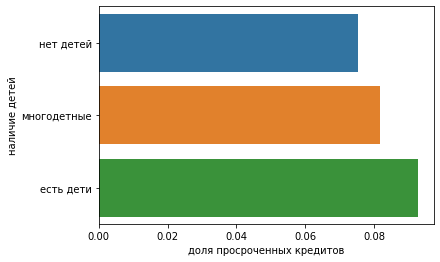

In [37]:
#Для оценки зависимости сгруппируем данные.
children_set=data.groupby('children')['debt'].mean().sort_values()
sns.barplot(x=children_set.values,y=children_set.index).set(xlabel='доля просроченных кредитов', ylabel='наличие детей') #Рисуем график для наглядности.

**Вывод** Зависимость есть. Люди, у которых нет детей, не склонны к формированию задолжности по кредитам. При этом многодетные семьи чаще отдают кредиты в срок, чем просто семьи с детьми. 

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

[Text(0.5, 0, 'доля просроченных кредитов'),
 Text(0, 0.5, 'семейное положение')]

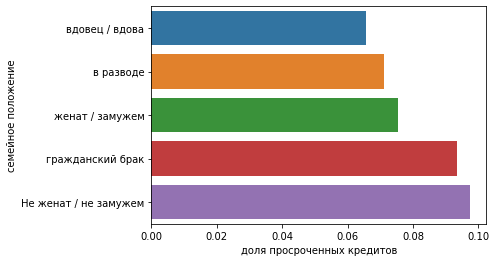

In [38]:
#Для оценки зависимости сгруппируем данные.
family_status_set=data.groupby('family_status')['debt'].mean().sort_values()
sns.barplot(x=family_status_set.values,y=family_status_set.index).set(xlabel='доля просроченных кредитов', ylabel='семейное положение') #Рисуем график для наглядности.

**Вывод** Зависимость есть. Люди состоящие или состоявшие в браке чаще отдают кредит без задолжности. Люди не состоящие, в законном браке склонны к формированию задолжности по кредиту.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

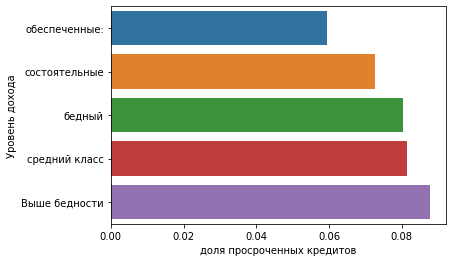

In [39]:
#Для оценки зависимости сгруппируем данные.
monthly_income_set=data.groupby('monthly_income')['debt'].mean().sort_values()
sns.barplot(x=monthly_income_set.values,y=monthly_income_set.index).set(xlabel='доля просроченных кредитов', ylabel='Уровень дохода'); #Рисуем график для наглядности.

**Вывод** Зависимость есть. Обеспеченные граждане мение склонны к формированию задолжности по кредитам. При этом бедные несколько реже имеют задолжность по кредитам, чем средний класс.

- Как разные цели кредита влияют на его возврат в срок?

[Text(0.5, 0, 'доля просроченных кредитов'), Text(0, 0.5, 'цель кредита')]

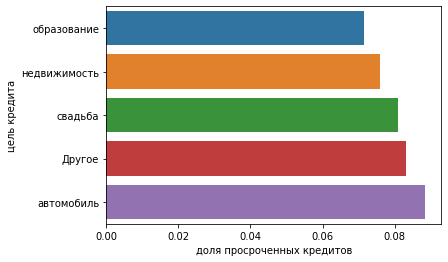

In [40]:
#Для оценки зависимости сгруппируем данные.
purpose_set=data.groupby('purpose')['debt'].mean().sort_values()
sns.barplot(x=purpose_set.values,y=purpose_set.index).set(xlabel='доля просроченных кредитов', ylabel='цель кредита') #Рисуем график для наглядности.

**Вывод** Зависимость есть. Люди, берущие долгосрочные кредиты на образование и недвижимость менее склонны к формированию задолженности. Вероятно, решения в этом случае принимаются более взвешенно. Чаще всего задолженность возникает при покупке в кредит автомобиля, что обьяснимо (менее надежный пассив, нежели недвижимость).

## Шаг 4. Общий вывод

Для банка удобен клиент без детей, с высоким доходом, состоящий или состоявший в законном браке, берущий кредит на покупку недвижимости.
Для банка не удобен клиент с детьми, средним доходом, не состоящий в законном браке, берущий потребительский кредит или кредит на автомобиль. Необходимо разобраться с данными по стажу. Там есть значения, которые явно не отражают действительность.